# BELGIUM TRAIN DELAYS ANALYSIS

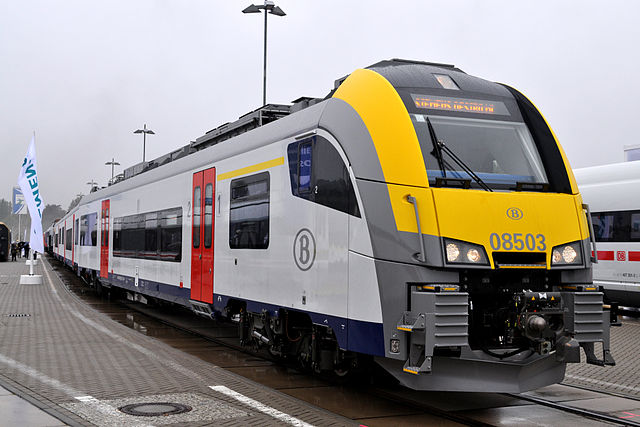

In [ ]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import calendar

%matplotlib inline

#scikitlearn
from sklearn.model_selection import train_test_split

# tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train_delay_df = pd.read_csv('Data_raw_punctuality_202201.csv')

In [ ]:
train_delay_df.sample(10)

This dataset contains the train travels information in Belgium for the month of January, 2022. The month of Febuary to December are also available and can be merged together for better exploration. Each months contains over 1 million observations. I choose to perform my analysis on only one month to avoid freezing or crashing of my local machine.

#### Feature Description

DATDEP - Date of departure    
TRAIN_NO - Train number    
RELATION - Train types (e.g Intercity(IC), Local train (L), etc)   
TRAIN_SERV - Railway operator    
PTCAR_NO - Measuring point number    
LINE_NO_DEP - Departure line    
REAL_TIME_ARR - Actual arrival time    
REAL_TIME_DEP - Actual departure time    
PLANNED_TIME_ARR - Planned arrival time    
PLANNED_TIME_DEP - Planned departure time    
DELAY_ARR - Delay at arrival    
DELAY_DEP - Delay at departure    
RELATION_DIRECTION - Relation direction (Route)   
PTCAR_LG_NM_NL - Stopping place    
LINE_NO_ARR - Arrival line    
PLANNED_DATE_ARR - Planned arrival date    
PLANNED_DATE_DEP - Planned departure date    
REAL_DATE_ARR - Actual arrival date    
REAL_DATE_DEP - Actual departure date    

### Checking the structure of the Dataset

In [ ]:
train_delay_df.shape

In [ ]:
train_delay_df.info()

In [ ]:
train_delay_df.isnull().sum()

### Data Cleaning and preprocessing

Here, I will:
- convert datatype of `DATE` features to `datetime` datatype. This will be helpful for my analysis.  
- Drop features with `null` values.
- Clean the `RELATION_DIRECTION` feature, thereby creating one or more new features.
- Drop columns that will not be useful.

Other preproccessing actions may be done during the Exploratory Data Analysis phase. 

#### Drop all Null values.

In [ ]:
train_delay_df = train_delay_df.dropna()

In [ ]:
train_delay_df.isnull().sum()

#### Convert data types to Datetime

In [ ]:
#converting the object type to Hour:Minute:Second datetime type
train_delay_df['REAL_TIME_ARR'] = pd.to_datetime(train_delay_df['REAL_TIME_ARR'], format='%H:%M:%S')
train_delay_df['REAL_TIME_DEP'] = pd.to_datetime(train_delay_df['REAL_TIME_DEP'], format='%H:%M:%S')
train_delay_df['PLANNED_TIME_ARR'] = pd.to_datetime(train_delay_df['PLANNED_TIME_ARR'], format='%H:%M:%S').dt.time
train_delay_df['PLANNED_TIME_DEP'] = pd.to_datetime(train_delay_df['PLANNED_TIME_DEP'], format='%H:%M:%S').dt.time

#converting the object type datetime type
#train_delay_df['DATDEP'] = pd.to_datetime(train_delay_df['DATDEP'], format='%d%b%Y')
train_delay_df['PLANNED_DATE_ARR'] = pd.to_datetime(train_delay_df['PLANNED_DATE_ARR'], format="%d%b%Y")
train_delay_df['PLANNED_DATE_DEP'] = pd.to_datetime(train_delay_df['PLANNED_DATE_DEP'], format="%d%b%Y")
train_delay_df['REAL_DATE_ARR'] = pd.to_datetime(train_delay_df['REAL_DATE_ARR'], format='%d%b%Y')
train_delay_df['REAL_DATE_DEP'] = pd.to_datetime(train_delay_df['REAL_DATE_DEP'], format='%d%b%Y')

#### Create one or more features.

- The `RELATION_DIRECTION` feature tells where the starts its journey (origin) to its final stop (destination). I will extract the start location and the stop location from this feature, creating two seperate features.  

However, `PTCAR_LG_NM_NL` are temporary stop locations where the trains stop to either pick up or drop off passengers.

In [ ]:
#Remove the train_type name strings before the colon(:)
train_delay_df['RELATION_DIRECTION'] = train_delay_df['RELATION_DIRECTION'].apply(lambda x: x.split(": ")[1])

#Create a start location feature
train_delay_df['START_LOCATION'] = train_delay_df['RELATION_DIRECTION'].apply(lambda x: x.split(" ->")[0])

#Creating a new feature
train_delay_df['FINAL_STOP_LOCATION'] = train_delay_df['RELATION_DIRECTION'].apply(lambda x: x.split( "> ")[1])

# dropping unwanted feature
train_delay_df = train_delay_df.drop("RELATION_DIRECTION", axis=1)

- I will also create `day_of_departure` and `hour_of_departure` features by extracting the day and the hour that the train departed from `REAL_DATE_DEP` and `REAL_TIME_DEP` respectively.

In [ ]:
#Create day_of_departure and arrival
train_delay_df["DAY_OF_DEPARTURE"] = train_delay_df["REAL_DATE_DEP"].apply(lambda x: x.strftime("%A"))
train_delay_df["DAY_OF_ARRIVAL"] = train_delay_df["REAL_DATE_ARR"].apply(lambda x: x.strftime("%A"))

#Create hour of departure
train_delay_df['HOUR_OF_DEPARTURE'] = train_delay_df.REAL_TIME_DEP.dt.hour.astype(int)
#Create hour of arrival
train_delay_df['HOUR_OF_ARRIVAL'] = train_delay_df.REAL_TIME_ARR.dt.hour.astype(int)

train_delay_df['REAL_TIME_ARR'] = train_delay_df['REAL_TIME_ARR'].dt.time
train_delay_df['REAL_TIME_DEP'] = train_delay_df['REAL_TIME_DEP'].dt.time

- A categorical feature(s) that tells if a train delayed (in arrival or depature) or not will also be helpful.

In [ ]:
#Creating new DELAYED categorical features
train_delay_df['DELAYED_ARRIVAL'] = train_delay_df.apply(lambda x: 'Yes' if x['DELAY_ARR'] > 0 else 'No', axis=1)
train_delay_df['DELAYED_DEPARTURE'] = train_delay_df.apply(lambda x: 'Yes' if x['DELAY_DEP'] > 0 else 'No', axis=1)

In [ ]:
##combine date column and time column
train_delay_df['ARRIVAL_DATE_TIME'] = pd.to_datetime(
    train_delay_df['REAL_DATE_ARR'].astype(str) + ' ' + train_delay_df['REAL_TIME_ARR'].astype(str))

train_delay_df['DEPARTURE_DATE_TIME'] = pd.to_datetime(
    train_delay_df['REAL_DATE_DEP'].astype(str) + ' ' + train_delay_df['REAL_TIME_DEP'].astype(str))

In [ ]:
#checking the new dataframe
train_delay_df.sample(5)

#### Drop Columns

In [ ]:
# List of columns to be dropped
drop_cols = ['PTCAR_NO', 'DATDEP', 'TRAIN_NO']
train_delay_df.drop(columns=drop_cols, inplace=True)

In [ ]:
train_delay_df.shape

In [ ]:
train_delay_df.info()

### 1. The list of Railway Operators

In [ ]:
train_delay_df['TRAIN_SERV'].unique()

There are three railway operators.

### 2. The List of Train types

In [ ]:
train_delay_df['LINE_NO_ARR'].unique()

There are different train types here; traveling either domestic or international.
- L (L 1-50, A,B,L,....) are **Local** trains that generally connect cities, but they also stop at every station along the route.     
- IC (Inter City) trains connect Belgium’s large cities. These trains only stop at the biggest train stations and sometimes cross international borders.
- ICE, THAL, TGV, EURST are Regular international trains.

In [ ]:
def rail_ops_trains(railop):
    rail_op = train_delay_df[train_delay_df['TRAIN_SERV'] == railop]
    rail_op_train_types = rail_op['RELATION'].unique()
    return rail_op_train_types

In [ ]:
rail_ops_trains('SNCB/NMBS')

In [ ]:
list(rail_ops_trains('EUROSTARFR'))

In [ ]:
list(rail_ops_trains('THI-FACT'))

In [ ]:
px.histogram(train_delay_df, x="TRAIN_SERV", 
             title="most active railway operator").update_xaxes(categoryorder='total descending')

`SNCB/NMBS` is the only railway operator that travels both Domestic and International. It is also the most active.

### 3. The most travelling train type in SNCB/NMBS.

I would like to find out which train type is always busy in the SNCB/NMBS railway operation.

In [ ]:
px.histogram(train_delay_df[train_delay_df['TRAIN_SERV'] == 'SNCB/NMBS'], x="RELATION", 
             title="most busy train type").update_xaxes(categoryorder='total descending')

It can be seen on the bar chart that `Intercity 25` is the most busy train type in the SNCB/NMBS railweay operation. InterCity trains are the top most used train type, and i can say that passengers mainly travel from one big city to another in Belgium, unlike Local trains that may travel short distances with a few temporary stops.

### 4.  Proportion of trains delayed and not delayed in terms of departure

In [ ]:
#create pie chart
train_delay_df['DELAYED_DEPARTURE'].value_counts().plot.pie(autopct='%1.0f%%')

### 5.  Proportion of trains delayed and not delayed in terms of arrival

In [ ]:
#create pie chart
train_delay_df['DELAYED_ARRIVAL'].value_counts().plot.pie(autopct='%1.0f%%')

### 6. What day are trains mostly busy?

In [ ]:
# creating a function to plot a bar chart 
def most_busy_day(df,column):
    #remove all the zero values
    df = df[df.DAY_OF_DEPARTURE != 'nan']
    #plotting graph
    plt.figure(figsize=(10,5))
    data = df[str(column)].value_counts()
    ax = sns.barplot(x = data.index, y = data, order= data.index, palette='dark', edgecolor="black")
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                fontsize=11, ha='center', va='bottom')
    plt.title(f'Most busy train day', fontsize=14)
    plt.xlabel('Days')
    plt.ylabel('Train depature count')
    plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.xticks(rotation=90)
    plt.show()

# Call Function
most_busy_day(train_delay_df,'DAY_OF_DEPARTURE')

- Monday is the most busy day for train travel and it is also the first day of work. Majority of the passengers travelling on Monday can be assumed to be leaving for work.
- Saturdays and Sundays are the least busy train days since most people will be enjoying their weekends indoor.

### In what hour(s) of the day is train delay  mostly experienced?

In [ ]:
# plotting categorical features
fig, ax=plt.subplots(nrows=2, figsize=[10,10])
sns.countplot(data=train_delay_df, x='HOUR_OF_ARRIVAL', hue='DELAYED_ARRIVAL',
ax=ax[0])
ax[0].legend(title='Delayed arrival hours')
sns.countplot(data=train_delay_df, x='HOUR_OF_DEPARTURE', hue='DELAYED_DEPARTURE',
 ax=ax[1])
ax[1].legend(title='Delayed depature hours')

fig.suptitle('Count of train delays by hours', fontsize=18)
plt.show()

Observations:
- Trains delays on both arrival and departure usually occur mostly between 7am - 9am, and also between 5pm - 7pm. This can be seen as the time when passengers are going to work and when they are returning from work.
- Trains travel at 2am very less often.
- Fewer trains travel bewteen 12am midnight - 4am in the morning.

### What day is train delay mostly experienced?

In [ ]:
#plot grouped bar chart
px.histogram(train_delay_df, x="DAY_OF_DEPARTURE", 
             title="Day of most depature delay", 
             color='DELAYED_DEPARTURE', barmode = 'group')

As Monday is the most busy day for train travels, It is also the day that travel delays are experienced by passengers.

### What is the average arrival delay (in seconds) by day of the week?

In [ ]:
# Creating box plot
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=train_delay_df[train_delay_df['DELAYED_ARRIVAL']=='Yes'], 
                                x="DAY_OF_ARRIVAL", y="DELAY_ARR", showfliers=False, order=order);

- Train travels on weekdays (Monday-Friday), especially on Mondays have longer delays as compared to Train travels on weekends (Saturday-Sunday).     

In [ ]:
# Creating box plot
sns.boxplot(data=train_delay_df[train_delay_df['DELAYED_ARRIVAL']=='Yes'], 
                                x="HOUR_OF_ARRIVAL", y="DELAY_ARR", showfliers=False);

This boxplot raises an eyebrow. It was observed earlier that Train rarely travel at 2am. And now, It is observed that Trains travelling at that time usualy arrive very late (as late as averagely 30 minutes) and departs late as well.

- Low delay time is usually experienced around 4am-5am.

Let me take a another look at 2am train travels.

In [ ]:
early_travel = train_delay_df[train_delay_df['HOUR_OF_ARRIVAL'] == 2]
early_travel[['RELATION', 'LINE_NO_DEP', 'LINE_NO_ARR', 'DELAY_ARR', 'DELAY_DEP', 
              'START_LOCATION', 'FINAL_STOP_LOCATION', 'HOUR_OF_ARRIVAL' ]]

- 2am Trains are `Intercity 01` trains.
- They travel from OOSTENDE to EUPEN
- They usually run on rail line 36

### Train types with the highest Arrival delay count

In [ ]:
px.histogram(train_delay_df[train_delay_df['DELAYED_ARRIVAL'] != 'Yes'], x="RELATION", 
             title="Delay count").update_xaxes(categoryorder='total descending')

`Intercity` trains are known to have the most tain delay counts.

In [ ]:
px.histogram(train_delay_df[train_delay_df['DELAYED_ARRIVAL'] != 'No'], x="RELATION", 
             title="Delay count").update_xaxes(categoryorder='total descending')

### `Intercity 25` Train travels

In [ ]:
#extract details of IC 25 from dataframe and create line plot
ic_25 = train_delay_df[train_delay_df['RELATION'] == 'IC 25']
ic_25 = ic_25[['RELATION', 'ARRIVAL_DATE_TIME', 'LINE_NO_DEP', 'LINE_NO_DEP', 'DELAY_ARR', 'DELAY_DEP']]
ic_25.sample(10)

In [ ]:
ic_25 = ic_25.sort_values(by='ARRIVAL_DATE_TIME')
fig = px.line(ic_25, x='ARRIVAL_DATE_TIME', y="DELAY_ARR")
fig.show()

In [ ]:
# create function to plot time delay on any train type
def delay_line_plot(relation):
    train_type = train_delay_df[train_delay_df['RELATION'] == relation]
    train_type = train_type[['ARRIVAL_DATE_TIME', 'DELAY_ARR', 'DELAY_DEP']]
    train_type = train_type.sort_values(by='ARRIVAL_DATE_TIME')
    fig = px.line(train_type, x='ARRIVAL_DATE_TIME', y="DELAY_ARR")
    return fig.show()

In [ ]:
delay_line_plot('IC 01')

### Most travelled Railway line

In [ ]:
px.histogram(train_delay_df, x="LINE_NO_ARR", 
             title="Most used rail line").update_xaxes(categoryorder='total descending')

- The top 3 frequently used rail way lines are `161`, `36` and `25`.
As observed earlier, `Intercity 01` runs only on line 36 at 2am. And it also has the highest delay period.

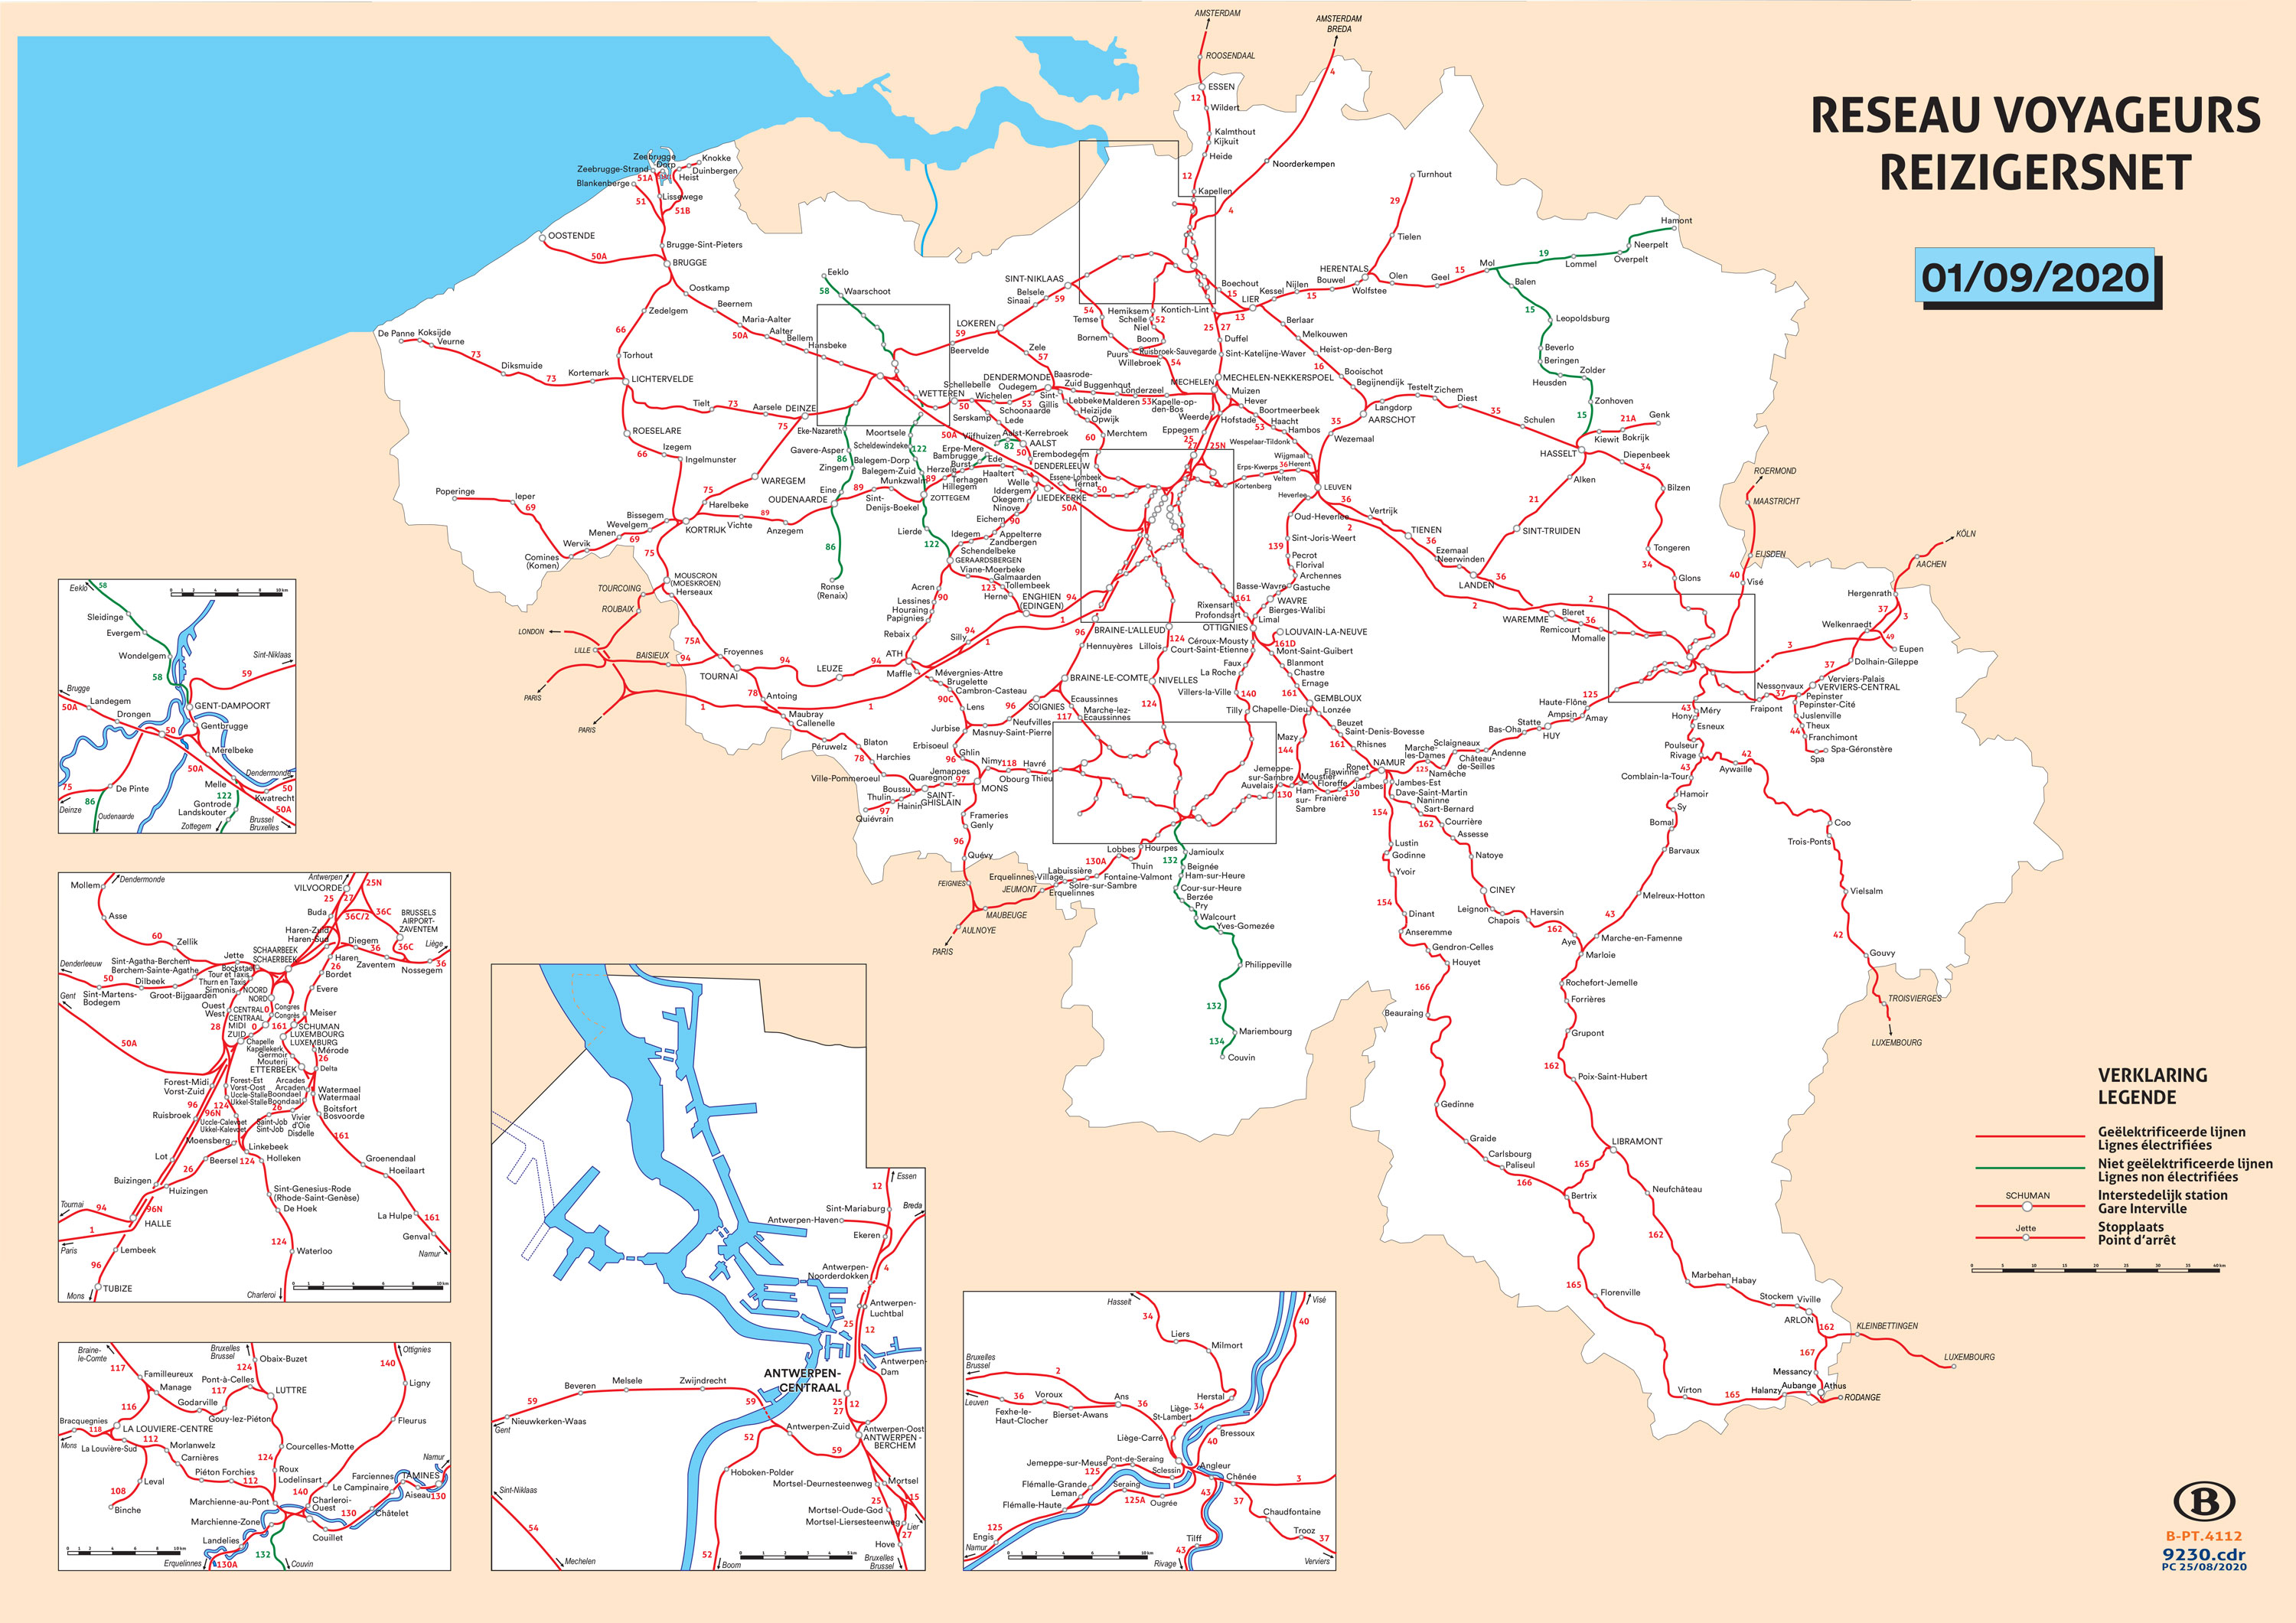

We can view the above map [here](https://cdn.belgiantrain.be/-/media/images/travel-info/leaflets/network-map-large.ashx?la=en&v=09622a20277c45bbba231663e06267fb&hash=3F5A8A4A1A6B695C861129E2797BB91E3BEB2C9B) to observe the different route of the train lines. 

### List of trains that run on Line 161

In [ ]:
list(train_delay_df[train_delay_df["LINE_NO_ARR"] == '59B']['RELATION'].unique())

### FEATURE ENGINEERING

On this phase of our notebook, we will: 

- Select the important columns needed for building an accurate regression model, to predict train arrival delays(in seconds).
- Select only the top 40 most frequent train types and rename the rest as `others`.
- Convert features with catergorical values to numeric.

#### Create new dataframe from selected features

In [ ]:
#create dataframe of selected features for modeling
new_df = train_delay_df[['LINE_NO_ARR', 'RELATION', 'HOUR_OF_ARRIVAL', 'DELAY_ARR',
                         'DAY_OF_ARRIVAL', 'START_LOCATION', 'FINAL_STOP_LOCATION']]

In [ ]:
new_df.sample(5)

#### Selecting top 40 values of categorical features

For train lines

In [ ]:
# make a list of the top 40 most frequent categories of the column
top_40_lines = [occ for occ in new_df['LINE_NO_ARR'].value_counts().sort_values(
    ascending = False).head(40).index]

In [ ]:
# list of all train lines
lines = list(new_df['LINE_NO_ARR'].unique())

#list of train lines that are not on the top 40 lines
others = [ x for x in lines if x not in top_40_lines ]

In [ ]:
#create function to rename least frequent train lines with `other lines`
def group_lines(input_df, others):
    for l in others:
        input_df['LINE_NO_ARR'].replace(l, 'other lines', inplace=True)
    
    return input_df

In [ ]:
#apply the function to the `new_df`
new_df = group_lines(new_df, others)

In [ ]:
new_df['RELATION'].value_counts().head(5)

#### ......

For train types

In [ ]:
# make a list of the top 40 most frequent categories of the column
top_40_train_types = [tt for tt in new_df['RELATION'].value_counts().sort_values(
    ascending = False).head(40).index]

In [ ]:
# list of all train lines
train_types = list(new_df['RELATION'].unique())

#list of train lines that are not on the top 40 lines
others = [x for x in train_types if x not in top_40_train_types]

In [ ]:
#create function to rename least frequent train types with `others`
def group_train_types(input_df, others):
    for t in others:
        input_df['RELATION'].replace(t, 'others', inplace=True)
    
    return input_df

In [ ]:
#apply the function to the `new_df`
new_df = group_train_types(new_df, others)

In [ ]:
new_df['RELATION'].value_counts().head(5)

#### .....

For Start location

In [ ]:
# make a list of the top 40 most frequent categories of the column
top_40_start_loc = [sl for sl in new_df['START_LOCATION'].value_counts().sort_values(
    ascending = False).head(40).index]

In [ ]:
# list of all train lines
start_locations = list(new_df['START_LOCATION'].unique())

#list of train lines that are not on the top 40 lines
others = [x for x in start_locations if x not in top_40_start_loc]

In [ ]:
#create function to rename least frequent train types with `others`
def group_start_locations(input_df, others):
    for loc in others:
        input_df['START_LOCATION'].replace(loc, 'OTHER LOCATION', inplace=True)
    
    return input_df

In [ ]:
#apply the function to the `new_df`
new_df = group_start_locations(new_df, others)

#### .....

For Stop location

In [ ]:
# make a list of the top 40 most frequent categories of the column
top_40_stop_loc = [sl for sl in new_df['FINAL_STOP_LOCATION'].value_counts().sort_values(
    ascending = False).head(40).index]

In [ ]:
# list of all train lines
stop_locations = list(new_df['FINAL_STOP_LOCATION'].unique())

#list of train lines that are not on the top 40 lines
others = [x for x in stop_locations if x not in top_40_stop_loc]

In [ ]:
#create function to rename least frequent train types with `others`
def group_stop_locations(input_df, others):
    for loc in others:
        input_df['FINAL_STOP_LOCATION'].replace(loc, 'OTHER LOCATION', inplace=True)
    
    return input_df

In [ ]:
#apply the function to the `new_df`
new_df = group_stop_locations(new_df, others)

#### Performing One-hot encoding on categorical features

In [ ]:
#checking the datatypes of the new dataframe
new_df.info()

In [ ]:
#select categorical datatypes
categorical_features = new_df.select_dtypes(include=['object']).columns.tolist()

In [ ]:
#using dummy encoder for one hot encoding
new_df_ohe = new_df

for col in categorical_features:
    col_ohe = pd.get_dummies(new_df[col], prefix=col)
    new_df_ohe = pd.concat((new_df_ohe, col_ohe), axis=1).drop(col, axis=1)

In [ ]:
new_df_ohe.shape

In [ ]:
new_df_ohe.head(5)

### Modeling with Tensorflow

Splitting the dataset

In [ ]:
X = new_df_ohe.drop('DELAY_ARR', axis=1)
y = new_df_ohe['DELAY_ARR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

In [ ]:
X_train.toarray()